In [15]:
import os
import pandas as pd
import torch
import numpy as np

def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K(object):
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K

def compare(a,b):
    tmp1 = int(a[:-4])
    tmp2 = int(b[:-4])
    return tmp1 - tmp2

def get_partition(df, num_of_steps, num_of_classes, end_time = None):
    if end_time == None:
        end_time = df['time'][len(df['time'])-1]
    res = torch.zeros(num_of_steps, num_of_classes + 1)
    dt = end_time/num_of_steps
    res[:,0] = end_time/num_of_steps
    for i in range(len(df['time'])):
        k = int(df['time'][i]/dt)
        if k == num_of_steps:
            k-=1
        res[k,int(df['event'][i])+1] += 1
    return res

def get_dataset(path_to_files, n_classes, n_steps):
    files = os.listdir(path_to_files)
    target = None
    if 'clusters.csv' in files:
        files.remove('clusters.csv')
        target = torch.Tensor(pd.read_csv(path_to_files+'/clusters.csv')['cluster_id'])
    #print(target)
    files = sorted(files, key = cmp_to_key(compare))
    data = torch.zeros(len(files), n_steps, n_classes + 1)
    for i, f in enumerate(files):
        df = pd.read_csv(path_to_files+'/'+f)
        data[i,:,:] = get_partition(df, n_steps, n_classes)
    return data, target

path_to_files = 'data/simulated_Hawkes/K2_C5'
N_STEPS = 32
n_runs = 3

data, target = get_dataset(path_to_files, 5, N_STEPS)
indices = np.random.permutation(data.shape[0])
data_train, target_train = data[indices[:9*data.shape[0]//10]],\
                           target[indices[:9*data.shape[0]//10]]
data_test, target_test = data[indices[9*data.shape[0]//10:]],\
                           target[indices[9*data.shape[0]//10:]]

import torch
from models.models import LSTM_cluster_point_processes
from utils.trainers import Trainer_clusterwise

device = 'cuda:0'

all_purs = []
all_purs_val = []
for i in range(n_runs):
    print('Run {}/{}'.format(i+1, n_runs))
    model = LSTM_cluster_point_processes(6,128, 3, 5, 2, N_STEPS, dropout = 0.3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)
    trainer = Trainer_clusterwise(model, optimizer, device, data_train, data_test,\
                              target_train, target_test, 2,\
                              max_epochs = 3, max_m_step_epochs = 30,\
                              lr_update_tol = 15, lr_update_param = 0.1,\
                              batch_size = 100)

    losses, purs, purs_val = trainer.train()
    all_purs+=purs
    all_purs_val += purs_val

import pickle

with open('all_purs.pkl', 'wb') as f:
    pickle.dump(all_purs, f)
with open('all_purs_val.pkl', 'wb') as f:
    pickle.dump(all_purs_val, f)
with open('all_purs_copy.pkl', 'wb') as f:
    pickle.dump(all_purs, f)
with open('all_purs_val_copy.pkl', 'wb') as f:
    pickle.dump(all_purs_val, f)

Run 1/3
Beginning e-step
tensor(720., device='cuda:0')
Purity for random model: 0.5236111111111111
Beginning m-step
Loss on sub_epoch 1/30: 9031.9697265625
Loss on sub_epoch 11/30: 6803.037179129465
Loss on sub_epoch 21/30: 6476.945242745535
On epoch 1/3 average loss = 6876.345359002976, purity = 0.5041666666666667
Validation loss = 4911.6640625, purity = 0.5625
Beginning e-step
tensor(720., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 6271.362723214285
Loss on sub_epoch 11/30: 6180.059779575893
Loss on sub_epoch 21/30: 6112.908272879465
Updating lr
On epoch 2/3 average loss = 6142.931096540178, purity = 0.5222222222222223
Validation loss = 4693.4423828125, purity = 0.5875
Beginning e-step
tensor(720., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 6035.561872209822
Loss on sub_epoch 11/30: 5982.805245535715
Loss on sub_epoch 21/30: 5943.15380859375
Updating lr
On epoch 3/3 average loss = 5977.374086216518, purity = 0.5583333333333333
Validation loss = 4651.0976

In [49]:
import pickle
with open('K4all_purs_10001.pkl', 'rb') as f:
    all_purs = pickle.load(f)
    
with open('K4all_purs_val_10001.pkl', 'rb') as f:
    all_purs_val = pickle.load(f)

In [50]:
import numpy as np
a = np.array(all_purs)

In [51]:
a[24::25, 1]

array([0.773125, 0.755   , 0.78    , 0.989375, 0.868125])

In [52]:
a[24::25, 1]

array([0.773125, 0.755   , 0.78    , 0.989375, 0.868125])

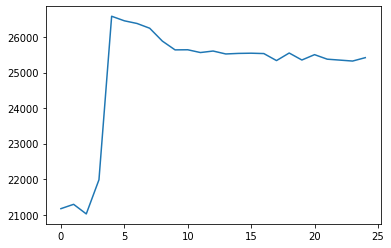

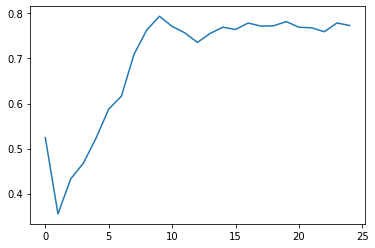

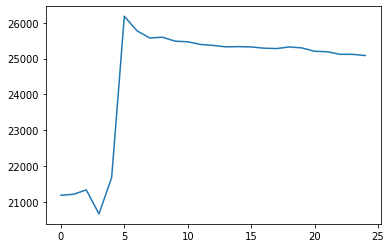

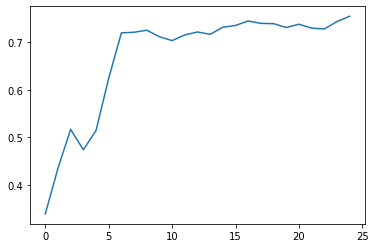

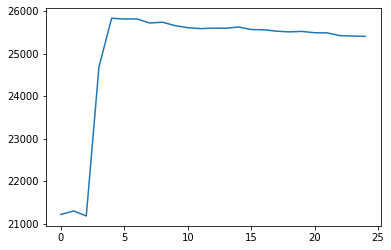

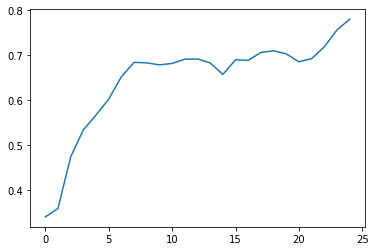

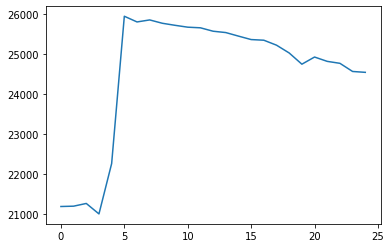

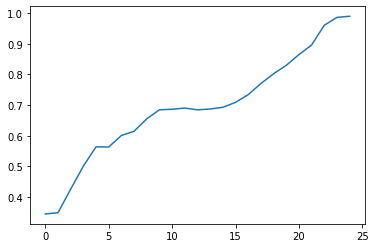

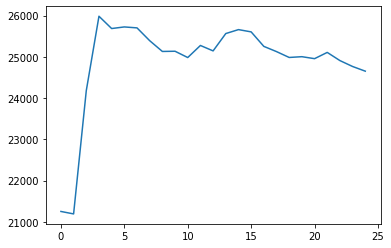

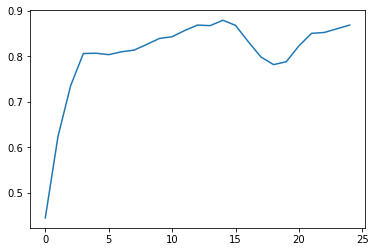

array([0.781875, 0.731875, 0.67875 , 0.56375 , 0.989375])

In [53]:
import matplotlib.pyplot as plt
import numpy as np
a = np.array(all_purs)
for i in range(1,6):
    plt.plot(a[25*(i-1):25*i,0])
    plt.show()
    plt.plot(a[25*(i-1):25*i,1])
    plt.show()
b = a[(np.arange(5)+1)*20-1,1]
b

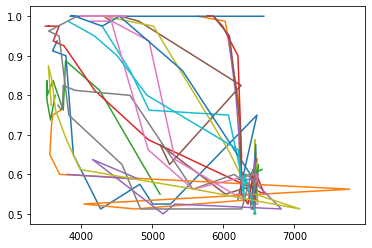